In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.signal
import pandas as pd
import matplotlib.patches as patches


From the dataset description:

There are subjective instability "flags" for the six types of instability: EGAM, BAAE (=LFM), BAE, RSAE, TAE, EAE.
-1 means that it washotnum't possible to assign a value with sufficient confidence. (For example, when the EAE frequency exceeds
                                           the ECE Nyquist frequency.)
0  means stable

1 means marginal; this might be coming & going or quite weak

2 means unstable for everything except the BAAE.  (For the BAAE, I later decided some of the modes I was calling
                                                   unstable were actually kinks or tearing modes.)

3 means the Christmas light pattern for the BAAE.  In hindsight, this is the equivalent of 2 for the other modes.

3 means rapid frequency chirping for the BAE.  In hindsight, virtually all BAE chirp but it's not always evident if the
                           FFT uses too many time points.  For the BAE, I now call both 2 & 3 "unstable."

#### Based on the description above, the scores are mapped to 0/1 as follows:
#### eae:   2 -> 1, otherwise 0
#### tae:    2 -> 1, otherwise 0
#### rsae:  2 -> 1, otherwise 0
#### baae: 3 -> 1, otherwise 0
#### bae: 2 and 3 -> 1, otherwise 0

In [2]:
def preprocess_label(fname):
    df_labels = pd.read_csv('uci_labels.txt', header=0, sep=',')
    df_labels.drop(['egam'], axis=1, inplace=True)
    df_labels.replace(
        {'baae': {-1:0 , 0:0 , 1:0, 2:0, 3:1, 4:0},
         'bae':   {-1:0 , 0:0 , 1:0, 2:1, 3:1, 4:0},
         'eae':   {-1:0 , 0:0 , 1:0, 2:1, 3:0, 4:0},
         'rsae':  {-1:0 , 0:0 , 1:0, 2:1, 3:0, 4:0},
         'tae':    {-1:0 , 0:0 , 1:0, 2:1, 3:0, 4:0}}, inplace=True)
    df_labels = df_labels[(df_labels.baae > 0) | (df_labels.bae > 0) | (df_labels.eae > 0) | (df_labels.rsae >0) | (df_labels.tae >0)]
    return df_labels

all_labels = preprocess_label('uci_labels.txt')
shotlist= all_labels.shot.unique()

In [4]:
# Spectrogram parameters
datapath  = '/scratch/gpfs/aonelson/ml_database/ECE_data/'
nperseg = 1024 # default 256
noverlap = nperseg / 4 # default: nperseg // 8
fs = 500000 # raw signal sample rate is 4MHz
window = 'hamm'
scaling = 'density' # {'density', 'spectrum'}
detrend = 'linear' # {'linear', 'constant', False}
eps = 1e-11

In [15]:
# set the shot number and the ECE channel ('\\tecefXX') to plot 
shotnum = shotlist[275] # Select a shot from the list
chn = '\\tecef07' # Select the ECE channel number
win = 200 # Set the width (in ms) of the white rectangle aournd the instability time in the plot 

/home/aj17/.conda/envs/azaplasma1/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


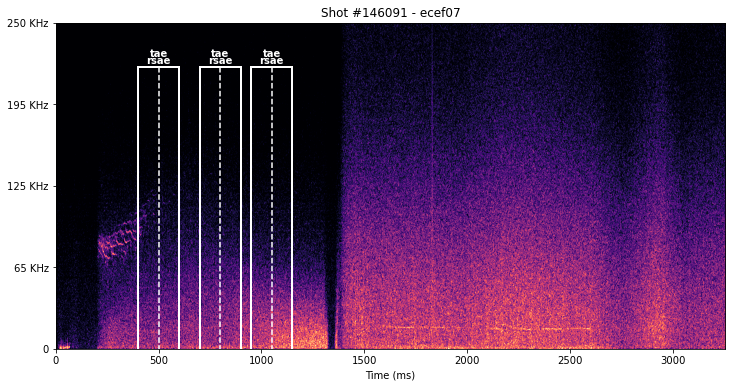

In [18]:
shot_label = all_labels[all_labels['shot']==shotnum]
plot_marks = shot_label.apply(lambda row: row[row == 1].index, axis=1).values
ece_data = pickle.load(open(datapath+'ece_'+str(shotnum)+'.pkl','rb'))


# Extracting the spectrogram from the signal
sig_in = ece_data[chn]

f, t, Sxx = scipy.signal.spectrogram(sig_in, nperseg=nperseg, noverlap=noverlap,fs=fs, window=window,scaling=scaling, detrend=detrend)
img = np.flipud(np.log(Sxx + eps))
gray=(255-255*(img-np.min(img))/(np.max(img)-np.min(img))).astype('uint8')
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1, 1)
vmin,vmax=[100,200]
gray[gray<vmin]=vmin
gray[gray>vmax]=vmax




ax1 = plt.subplot(gs[0])
plt.title('Shot #'+str(shotnum)+' - '+chn[2:])
ax1.imshow(gray,cmap='magma_r',aspect='auto')
plt.ylim([nperseg/2,0])
plt.xlabel('Time (ms)')
ax1.set_yticks([0,128,256,384,512])
ax1.set_yticklabels(['250 KHz','195 KHz','125 KHz','65 KHz','0'])


for tm,mrk in zip(shot_label['time'],plot_marks):
    ax1.plot([tm,tm],[70,nperseg/2],'w--')
    ax1.add_patch(
        patches.Rectangle((tm-(win/2), 70), win, nperseg/2, ec='w', fc='none',lw=2,ls='-'))
    for i,m in enumerate(mrk):
        ax1.annotate(m, (tm, 60-(i*12)), color='w', weight='bold', 
                    fontsize=10, ha='center', va='center')
plt.savefig('../Shot'+str(shotnum)+'-'+chn[2:]+'.png', bbox_inches='tight', dpi=300, frameon='false',facecolor='w')